<a href="https://colab.research.google.com/github/shiyuhu1933/EC-523-final-project/blob/main/train_and_test_version_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
import torch
import os
import h5py
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import math
import time
import datetime
from torch import nn, optim
import matplotlib.pyplot as plt 
import torchvision.transforms as T
import pandas as pd
import seaborn as sns
import random

In [3]:
drive.mount('/content/gdrive')

DATASET_GOOGLE_DRIVE_PATH = '/content/gdrive/MyDrive/Deep Learning /data_hdf5_100_10'


def get_file_name(files_list):
  with open(files_list) as f:
    return [line.rstrip()[:] for line in f]

class FaceMaskData(torch.utils.data.Dataset):

  def __init__(self, mode, config, transform=None):

    self.data_dir = DATASET_GOOGLE_DRIVE_PATH
    self.transform = transform

    if mode == 'train':
      self.files = get_file_name(os.path.join(self.data_dir, 'train_files.txt'))
    else:
      self.files = get_file_name(os.path.join(self.data_dir, 'test_files.txt'))

    image = []
    label = []

    for dataset in self.files:
      path = os.path.join(self.data_dir, dataset)
      self.file = h5py.File(path, 'r')
      self.total_num_imgs, self.H, self.W, self.C = self.file['image'].shape
      image.append(self.file['image'][:])
      label.append(self.file['labels'][:])

    self.image= np.vstack(image)
    self.label = np.vstack(label)

    self.num_images = len(self.image) 
    self.num_classes = len(np.unique(self.label))

  def __getitem__(self, index):
    """Return one image and its corresponding attribute label."""
    image = self.image[index]
    label = self.label[index]
    if self.transform:
        image = self.transform(image)
    return image, torch.FloatTensor(label)

  def __len__(self):
    return self.num_images
      
  def get_num_class(self):
    return self.num_classes

Mounted at /content/gdrive


In [4]:
def get_configuration(batch_size):
    config = {}
    config['device'] = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    config['batch_size'] = batch_size
    config['num_workers'] = 1
    config['lr'] = 0.0001
    return config

def image_to_rgb(images):
  imgs = []
  for i in range(len(images)):
    image_r = torch.unsqueeze(images[i,:,:,0], 0)
    image_g = torch.unsqueeze(images[i,:,:,1], 0)
    image_b = torch.unsqueeze(images[i,:,:,2], 0)
    image_split_rgb = torch.cat((image_r, image_g, image_b), 0)
    image_split_rgb = torch.unsqueeze(image_split_rgb, 0)
    imgs.append(image_split_rgb)
  return torch.cat(imgs)

def print_network(model, name):
  num_params = 0
  print("\n")
  print("model name", name)
  print(model)
  num_params = sum([par.numel() for par in model.parameters()])
  print("The number of parameters: {}".format(num_params))

def save_model(model, step):
  save_model_path = "/content/gdrive/MyDrive/Deep Learning /models"
  model_path = os.path.join(save_model_path, 'model-{}.ckpt'.format(step))
  torch.save(model, model_path)
  print('Saved model checkpoints into {}...'.format(save_model_path))

def load_model(iters):
  path = "/content/gdrive/MyDrive/Deep Learning /models"
  model_path = os.path.join(path, 'model-{}.ckpt'.format(iters))
  model = torch.load(model_path)
  return model

In [5]:
config = get_configuration(batch_size=1024)
dataset = FaceMaskData('train', config)
data_loader = torch.utils.data.DataLoader(dataset=dataset,
                              batch_size=config['batch_size'],
                              shuffle=True, 
                              num_workers=config['num_workers'])
num_classes = dataset.get_num_class()

In [6]:

def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, norm_layer=None,
                 start_block=False, end_block=False, exclude_bn0=False):
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        if not start_block and not exclude_bn0:
            self.bn0 = norm_layer(inplanes)

        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)

        if start_block:
            self.bn2 = norm_layer(planes)

        if end_block:
            self.bn2 = norm_layer(planes)

        self.downsample = downsample
        self.stride = stride

        self.start_block = start_block
        self.end_block = end_block
        self.exclude_bn0 = exclude_bn0

    def forward(self, x):
        identity = x

        if self.start_block:
            out = self.conv1(x)
        elif self.exclude_bn0:
            out = self.relu(x)
            out = self.conv1(out)
        else:
            out = self.bn0(x)
            out = self.relu(out)
            out = self.conv1(out)

        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)

        if self.start_block:
            out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity

        if self.end_block:
            out = self.bn2(out)
            out = self.relu(out)

        return out

class iResNet(nn.Module):

    def __init__(self, block, layers, num_classes=num_classes, zero_init_residual=False, norm_layer=None, dropout_prob0=0.0):
        super(iResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self.inplanes = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = norm_layer(64)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(block, 64, layers[0], stride=2, norm_layer=norm_layer)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2, norm_layer=norm_layer)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2, norm_layer=norm_layer)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2, norm_layer=norm_layer)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        if dropout_prob0 > 0.0:
            self.dp = nn.Dropout(dropout_prob0, inplace=True)
            print("Using Dropout with the prob to set to 0 of: ", dropout_prob0)
        else:
            self.dp = None

        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)



    def _make_layer(self, block, planes, blocks, stride=1, norm_layer=None):
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        downsample = None
        if stride != 1 and self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.MaxPool2d(kernel_size=3, stride=stride, padding=1),
                conv1x1(self.inplanes, planes * block.expansion),
                norm_layer(planes * block.expansion),
            )
        elif self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion),
                norm_layer(planes * block.expansion),
            )
        elif stride != 1:
            downsample = nn.MaxPool2d(kernel_size=3, stride=stride, padding=1)

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, norm_layer,
                            start_block=True))
        self.inplanes = planes * block.expansion
        exclude_bn0 = True
        for _ in range(1, (blocks-1)):
            layers.append(block(self.inplanes, planes, norm_layer=norm_layer,
                                exclude_bn0=exclude_bn0))
            exclude_bn0 = False

        layers.append(block(self.inplanes, planes, norm_layer=norm_layer, end_block=True, exclude_bn0=exclude_bn0))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)

        if self.dp is not None:
            x = self.dp(x)

        x = self.fc(x)

        return x


In [7]:
class ArcFaceloss(nn.Module):
  def __init__(self, s=45.0, m=0.1, weight = None):
    super(ArcFaceloss, self).__init__()
    # x = tf.nn.l2_normalize(x, axis=1)
    self.weight = weight
    self.s = s
    self.cosm = math.cos(m)
    self.sinm = math.sin(m)
    self.th = math.cos(math.pi - m)
    self.mm = math.sin(math.pi - m) * m
  
  def forward(self, input, labels):
    num_classes = dataset.get_num_class()
    cost = F.normalize(input)
    sint = torch.sqrt(1.0 - torch.square(cost))
    cosmt = self.s * (self.cosm * cost - self.sinm * sint)
    k = torch.where(cost > self.th, cosmt, self.s * (cost - self.mm))
    
    label = torch.zeros_like(cost)
    label.scatter_(1, labels.view(-1, 1).long(), 1)

    output = (1 - label) * self.s * cost + label * k

    cross_entropy = nn.CrossEntropyLoss()
    output = cross_entropy(output, labels)

    return output


In [8]:
model = iResNet(BasicBlock, [3,4,14,3]).cuda()

In [9]:
# train

criterion = ArcFaceloss().cuda()
optimizer = optim.SGD(model.parameters(), lr=0.05, momentum =0.9, weight_decay=5e-4)

Epochs = 30

loss = []

print('Start training ...')
start_time = time.time()
for epoch in range(1, Epochs+1):
  model.train()

  loss_acc = 0 
  for i, data in enumerate(data_loader, 0):
    images, labels = data
    images, labels = images.float().cuda(), labels.cuda()
    images = image_to_rgb(images)
    labels = labels.type(torch.LongTensor).cuda()
    labels = labels.squeeze(-1)

    logits = model(images)

    loss = criterion(logits, labels)
    loss_acc += loss.item()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  loss_acc /= Epochs
  et = time.time() - start_time
  et = str(datetime.timedelta(seconds=et))[:-7]
  log = "Elapsed [{}], Iteration [{}/{}]".format(et, epoch, Epochs)
  log += ', Loss = %.8f'%(loss_acc)
  print(log)

  if epoch % 5 == 0:
    save_model(model, epoch)


Start training ...
Elapsed [0:00:45], Iteration [1/30], Loss = 15.55831690
Elapsed [0:01:31], Iteration [2/30], Loss = 15.10085290
Elapsed [0:02:17], Iteration [3/30], Loss = 14.53922634
Elapsed [0:03:02], Iteration [4/30], Loss = 13.59036401
Elapsed [0:03:48], Iteration [5/30], Loss = 12.40862363
Saved model checkpoints into /content/gdrive/MyDrive/Deep Learning /models...
Elapsed [0:04:36], Iteration [6/30], Loss = 10.95901551
Elapsed [0:05:22], Iteration [7/30], Loss = 9.60315452
Elapsed [0:06:08], Iteration [8/30], Loss = 8.09552409
Elapsed [0:06:53], Iteration [9/30], Loss = 6.70428640
Elapsed [0:07:39], Iteration [10/30], Loss = 4.90686014
Saved model checkpoints into /content/gdrive/MyDrive/Deep Learning /models...
Elapsed [0:08:27], Iteration [11/30], Loss = 3.45592284
Elapsed [0:09:13], Iteration [12/30], Loss = 4.45645862
Elapsed [0:09:58], Iteration [13/30], Loss = 2.22915845
Elapsed [0:10:44], Iteration [14/30], Loss = 1.21060866
Elapsed [0:11:30], Iteration [15/30], Loss =

In [10]:
# test

dataset = FaceMaskData('test', config)
test_loader = torch.utils.data.DataLoader(dataset=dataset,
                              batch_size=config['batch_size'],
                              shuffle=True, 
                              num_workers=config['num_workers'])
num_classes = dataset.get_num_class()
model = load_model(30)

correct = np.zeros((num_classes, 2)) 
counts = np.zeros((num_classes, 2))
conf_matrix = np.zeros((num_classes, num_classes))

with torch.no_grad():
  for i, data in enumerate(test_loader):
    images, labels = data
    images, labels = images.float().cuda(), labels.cuda()
    images = image_to_rgb(images)
    labels = labels.type(torch.LongTensor).cuda()
    labels = labels.squeeze(-1)
    output = model(images).cpu()
    preds = output.data.max(1, keepdim=True)[1].squeeze(1).numpy()

    for i in range(len(preds)):
      counts[labels[i]] += 1
      conf_matrix[preds[i]][labels[i]] += 1
      if labels[i] == preds[i]:
        correct[preds[i]] += 1

print("Accuracy %.4f "%np.mean(correct/counts))

Accuracy 0.9123 


Text(0.5, 114.0, 'Predicted label')

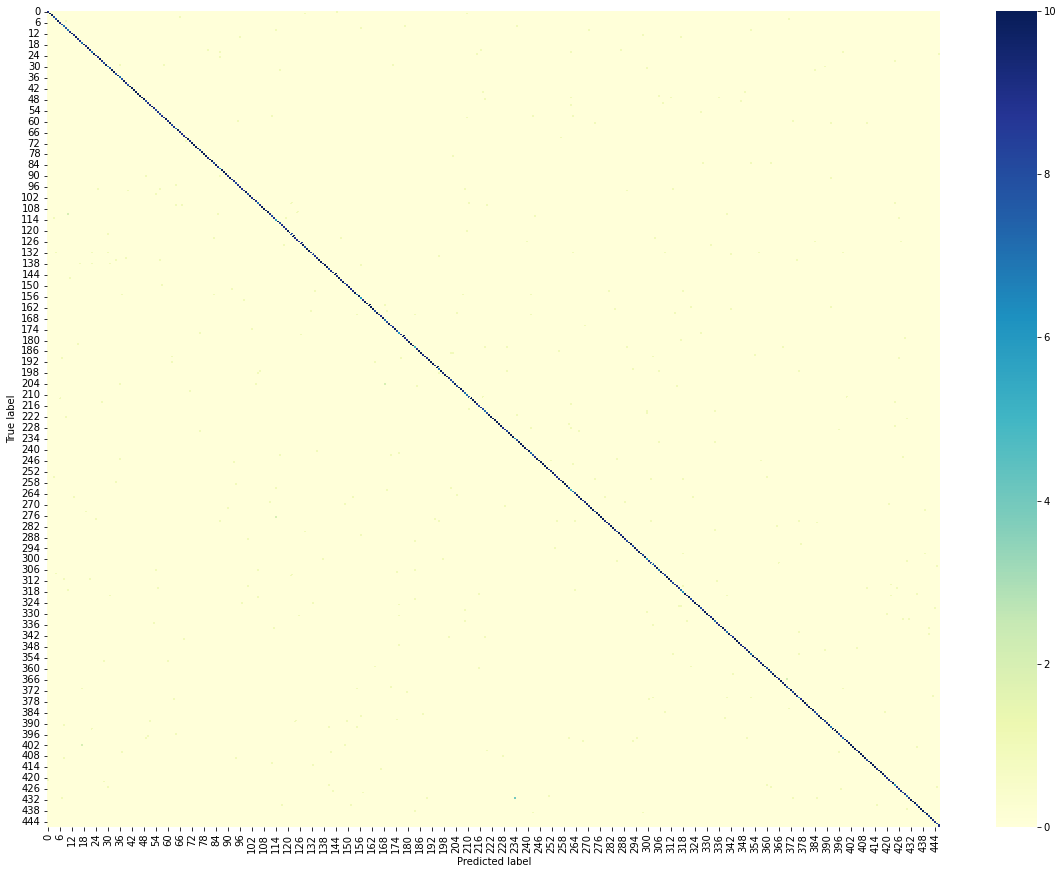

In [11]:
plt.figure(figsize=(20, 15))
df_cm = pd.DataFrame(conf_matrix).astype(int)
heatmap = sns.heatmap(df_cm, cmap="YlGnBu")

plt.ylabel('True label')
plt.xlabel('Predicted label')
